# 超参数和模型验证

## 模型验证

正确的模型验证方法，有train_test(holdout set)验证和交叉验证，不建议用同一套数据验证模型，对于一些模型，准确率肯定会是100%

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

### train_test

In [2]:
# 这样理解：训练测试分离是 交叉验证的一种特殊形式，因此放在该分支下，以后可能会放在 model_selection 下，也就是用于判断模型好坏的工具
from sklearn.cross_validation import train_test_split

/Users/vodka/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# 用KNN预测数据并测试准确率
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
model = KNeighborsClassifier(n_neighbors = 1)
X1,X2,y1,y2 = train_test_split(X,y,random_state = 0, train_size = 0.5)
model.fit(X1,y1)
y2_model = model.predict(X2)
accuracy_score(y2,y2_model)

0.90666666666666662

### 交叉验证

用 留出集 验证有一个缺点是失去了一部分训练的机会，在模型中有一半数据没有为模型训练做出贡献，这必然不是最优解，而且当训练数据集较小的时候显得捉襟见肘

In [4]:
y2_model = model.fit(X1,y1).predict(X2)
y1_model = model.fit(X2,y2).predict(X1)
accuracy_score(y1,y1_model),accuracy_score(y2,y2_model)

(0.95999999999999996, 0.90666666666666662)

五轮交叉检验

In [5]:
from sklearn.cross_validation import cross_val_score
cross_val_score(model,X,y,cv = 5) # score 就是指各个模型的准确率，就是通过交叉检验准确率来看模型优劣

array([ 0.96666667,  0.96666667,  0.93333333,  0.93333333,  1.        ])

LOO:LeaveOneOut,每次取出一个用于验证，其余的都用于训练，这时不能简单的只填一个 cv = len(x) 因为这样会随机拿出一个，而不是全部轮一遍

In [6]:
from sklearn.cross_validation import LeaveOneOut
cross_val_score(model,X,y,cv = LeaveOneOut(len(X))) 

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [7]:
scores = cross_val_score(model,X,y,cv = LeaveOneOut(len(X))) 
scores.mean()

0.95999999999999996

## 选择最优模型

模型各种验证方法，得到结果，目的是根据结果选择最优模型

### 偏差方差平衡

偏差： 模型总体的预测能力，预测整体结果是否有偏于实际情况，或者是无法完全预测出数据情况，一般模型越复杂，预测数据的能力越高，偏差会越来越小  
方差： 用不同训练数据集训练模型，模型最终效果的差异，对于高偏差的复杂模型，稍微改变一下训练数据，模型各个训练后的参数变化差异就大了，高方差

### 验证曲线

利用多项式模型来拟合数据，多项式的次数 degree 是一个变量，在 degree 变化的情况下，相应模型训练出来的训练集和测试集的效果，整体可以看做是验证曲线

In [8]:
# 涉及到将一个preprocessing 和 一个原有模型管道起来，就是将前者的 transform 放在X
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree = 2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                        LinearRegression(**kwargs))

In [9]:
# 创造数据
import numpy as np

def make_data(N,err = 1.0,rseed = 1):
    # 随机抽样数据
    rng = np.random.RandomState(rseed)
    X = rng.rand(N,1)**2
    y = 10 - 1./(X.ravel() + 0.1) # ravel: 将数据降维
    if err > 0:
        y += err * rng.randn(N)
    return X, y 

X,y = make_data(40)

/Users/vodka/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


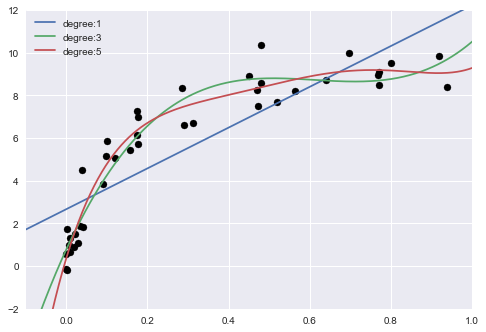

In [10]:
# 画三条曲线，大致看下不同degree的拟合效果
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # 设置图形样式

X_test = np.linspace(-0.1,1.1,500)[:,None]
plt.scatter(X.ravel(),y,color = 'black')
axis = plt.axis()
for degree in [1,3,5]:
    y_test = PolynomialRegression(degree).fit(X,y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label = 'degree:{0}'.format(degree))
plt.xlim(-0.1,1.0)
plt.ylim(-2,12)
plt.legend(loc = 'best')

究竟多项式的次数是多少，才能在偏差（欠拟合）与方差（过拟合）间达到平衡  
这时候就可以用到验证曲线

/Users/vodka/anaconda/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


Text(0,0.5,'score')

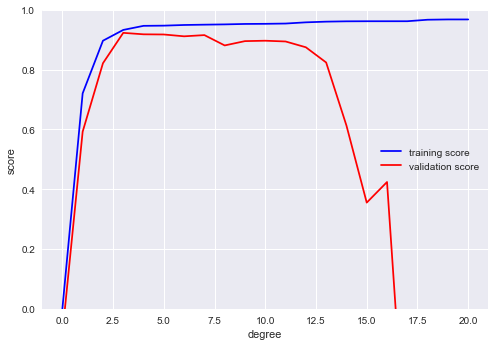

In [11]:
from sklearn.learning_curve import validation_curve
degree = np.arange(0,21)
train_score,val_score = validation_curve(PolynomialRegression(),
                                        X,y,
                                        'polynomialfeatures__degree',
                                        degree, cv = 7)  # 传的是一个Pipeline实例，validation_curve会根据实例的类衍生出不同degree的实例
plt.plot(degree, np.median(train_score,1), color = 'blue', label = 'training score')
plt.plot(degree, np.median(val_score,1), color = 'red', label = 'validation score')
plt.legend(loc = 'best')
plt.ylim(0,1)
plt.xlabel('degree')
plt.ylabel('score')

* 训练得分总是比验证得分高
* 训练得分随着模型复杂度的提升而单调递增
* 验证得分增长到最高点的时候由于过拟合而开始骤降

由上图可以看出，degree为3时模型你和效果可能最好

(-0.055501062186377917,
 0.99303155428258749,
 -0.74369482718170177,
 10.915746507848837)

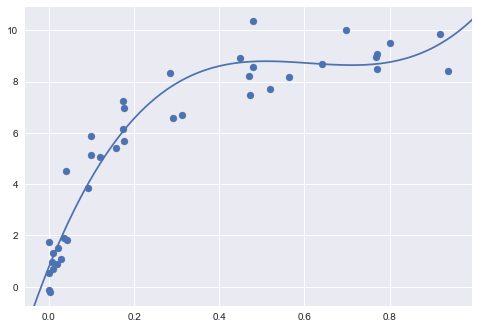

In [12]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
y_test = PolynomialRegression(3).fit(X,y).predict(X_test)
plt.plot(X_test.ravel(),y_test)
plt.axis(lim)

检查训练得分与验证得分之间的关系，可以让我们对模型的性能有更加直观的认识

## 学习曲线

指的是训练数据量大小与训练效果的关系

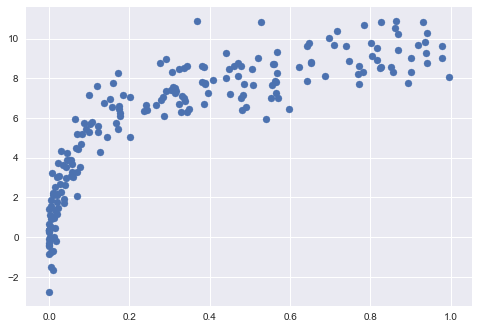

In [13]:
X2,y2 = make_data(200)
plt.scatter(X2.ravel(), y2)

Text(0,0.5,'score')

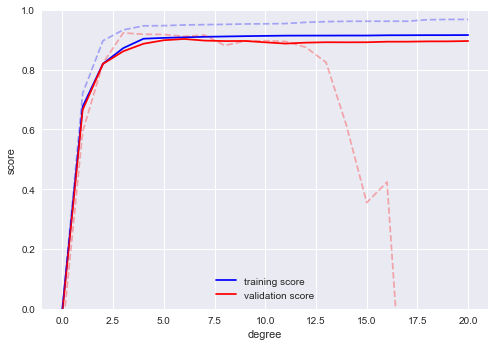

In [14]:
# 画出不同数据集的验证曲线看看先
degree = np.arange(21)
train_score2, val_score2 = validation_curve(PolynomialRegression(), X2, y2,
                                            'polynomialfeatures__degree', degree, cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3, linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3, linestyle='dashed')
plt.legend(loc='lower center')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score')

大数据集就不太会因为模型复杂度而在validation_score上降低预测效果，后面的系数都偏向于0

学习曲线：就是不同数据量下训练的分和验证得分的区别（固定了degree）
* 特定复杂度的模型对较小的数据容易过拟合：训练分较高，验证得分较低
* 特定复杂度的模型对较大的数据集容易欠拟合，训练的分不断降低，而验证得分会不断升高
* 模型的验证集得分永远不会高于训练集得分：两条曲线一直在靠近，但是永远不会交叉

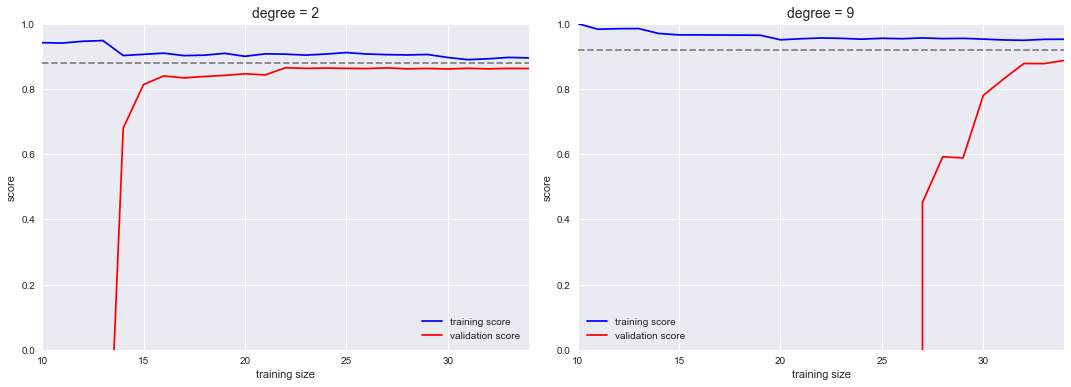

In [15]:
from sklearn.learning_curve import learning_curve
fig,ax = plt.subplots(1,2,figsize = (16,6))
fig.subplots_adjust(left=0.0625, right=0.95,wspace=0.1)

for i,degree in enumerate([2,9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                        X,y,cv = 7,
                                        train_sizes = np.linspace(0.3,1,25))
    ax[i].plot(N,np.mean(train_lc,1), color = 'blue', label = 'training score')
    ax[i].plot(N,np.mean(val_lc,1), color = 'red', label = 'validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]),N[0],N[-1], color = 'gray',linestyle = 'dashed')
    
    ax[i].set_ylim(0,1)
    ax[i].set_xlim(N[0],N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree),size = 14)
    ax[i].legend(loc = 'best')
    
    

复杂度较低的模型，用相对较小的数据就能达到相对最优的训练效果，模型较复杂的模型就需要大量的数据

## 网格搜索

验证曲线的多维版本，但是这里只提供验证分数，不提供训练分数了

In [16]:
from sklearn.grid_search import GridSearchCV

param_grid = {
    'polynomialfeatures__degree': np.arange(21),
    'linearregression__fit_intercept':[True,False],
    'linearregression__normalize':[True,False]
}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv = 7)

/Users/vodka/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [17]:
grid.fit(X,y)

GridSearchCV(cv=7, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'polynomialfeatures__degree': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20]), 'linearregression__fit_intercept': [True, False], 'linearregression__normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [18]:
# 存储了最优的params
grid.best_params_

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

(-0.055501062186377917,
 0.99303155428258749,
 -0.74369482718170177,
 10.915746507848837)

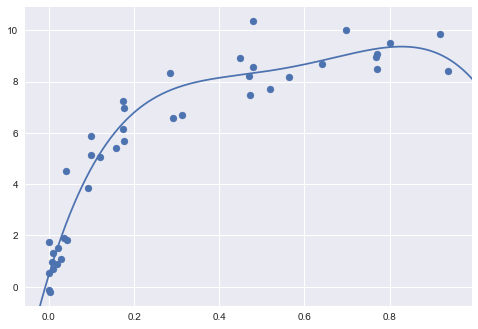

In [19]:
# 存储了最优的estimator
model = grid.best_estimator_

plt.scatter(X.ravel(),y)
lim = plt.axis()
y_test = model.fit(X,y).predict(X_test)
plt.plot(X_test.ravel(), y_test)
plt.axis(lim)